<a href="https://colab.research.google.com/github/hillahalevi/Ex3--ANN-CNN/blob/main/Ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 1

##  Setup

In [ ]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)
X = ((X / 255.) - .5) * 2

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(70000,)


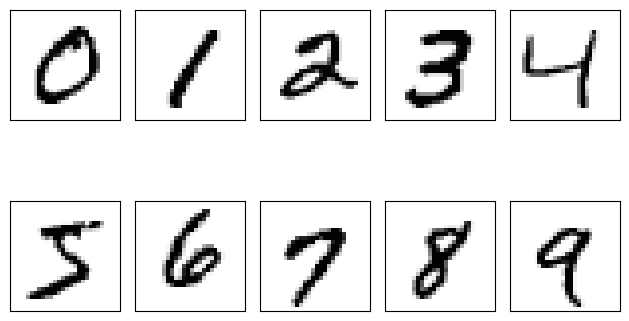

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

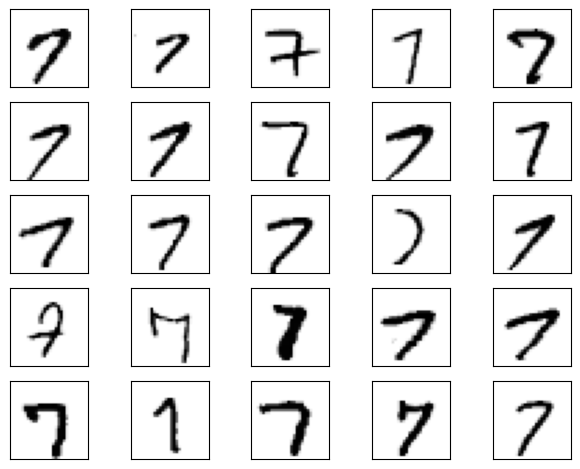

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

##Lets train the 3 models on the mnist dataset and compare their performance

### load data

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.datasets import fetch_openml

# Load the MNIST dataset
mnist = fetch_openml('mnist_784')
X, y = mnist.data.astype(float), mnist.target.astype(int)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [7]:
X = X.values
y = y.astype(int).values

X = ((X / 255.) - .5) * 2

# Convert labels to integers
num_classes = 10

# Split the data into training and test sets (70%/30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### NeuralNetMLPOne - one layer

####model

In [8]:
import numpy as np
##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLPOne:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

In [9]:
num_epochs = 50
minibatch_size = 100
def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]

def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

np.random.seed(123) # for the training set shuffling

####train

In [10]:
# Set up the model parameters
num_features = X_train.shape[1]
num_hidden = 50

# Initialize the model
model = NeuralNetMLPOne(num_features=num_features, num_hidden=num_hidden, num_classes=num_classes)

# Train the model
num_epochs = 100
learning_rate = 0.1
epoch_loss, epoch_train_acc, epoch_valid_acc = train(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, learning_rate=learning_rate)


Epoch: 001/100 | Train MSE: 0.05 | Train Acc: 73.79% | Valid Acc: 73.61%
Epoch: 002/100 | Train MSE: 0.03 | Train Acc: 84.79% | Valid Acc: 84.57%
Epoch: 003/100 | Train MSE: 0.03 | Train Acc: 87.52% | Valid Acc: 87.10%
Epoch: 004/100 | Train MSE: 0.02 | Train Acc: 88.86% | Valid Acc: 88.51%
Epoch: 005/100 | Train MSE: 0.02 | Train Acc: 89.88% | Valid Acc: 89.52%
Epoch: 006/100 | Train MSE: 0.02 | Train Acc: 90.48% | Valid Acc: 90.14%
Epoch: 007/100 | Train MSE: 0.02 | Train Acc: 90.80% | Valid Acc: 90.41%
Epoch: 008/100 | Train MSE: 0.02 | Train Acc: 91.23% | Valid Acc: 90.88%
Epoch: 009/100 | Train MSE: 0.02 | Train Acc: 91.51% | Valid Acc: 91.17%
Epoch: 010/100 | Train MSE: 0.01 | Train Acc: 91.78% | Valid Acc: 91.37%
Epoch: 011/100 | Train MSE: 0.01 | Train Acc: 91.97% | Valid Acc: 91.53%
Epoch: 012/100 | Train MSE: 0.01 | Train Acc: 92.16% | Valid Acc: 91.73%
Epoch: 013/100 | Train MSE: 0.01 | Train Acc: 92.40% | Valid Acc: 92.07%
Epoch: 014/100 | Train MSE: 0.01 | Train Acc: 92.44

#### evaluate

In [11]:
# Perform forward pass on the test set
_, probabilities_one = model.forward(X_test)

# Convert probabilities to one-hot encoded format
y_pred_onehot = int_to_onehot(probabilities_one.argmax(axis=1), num_labels=num_classes)

# Calculate the macro AUC score
macro_auc_one = roc_auc_score(int_to_onehot(y_test, num_labels=num_classes), y_pred_onehot, average='macro')

print(f"Macro AUC: {macro_auc_one:.4f}")


Macro AUC: 0.9747


### NeuralNetMLP - 2 layers

####model

In [12]:
import numpy as np

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden1, num_hidden2, num_classes, random_seed=123):
        self.num_classes = num_classes

        # Hidden layer 1
        rng = np.random.RandomState(random_seed)
        self.weight_h1 = rng.normal(loc=0.0, scale=0.1, size=(num_hidden1, num_features))
        self.bias_h1 = np.zeros(num_hidden1)

        # Hidden layer 2
        self.weight_h2 = rng.normal(loc=0.0, scale=0.1, size=(num_hidden2, num_hidden1))
        self.bias_h2 = np.zeros(num_hidden2)

        # Output layer
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden2))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer 1
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        # Hidden layer 2
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)

        return a_h1, a_h2, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: Output layer weights
        d_loss__d_a_out = 2. * (a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out)  # sigmoid derivative
        delta_out = d_loss__d_a_out * d_a_out__d_z_out

        # Gradients for output layer weights
        d_z_out__dw_out = a_h2
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        # Part 2: Hidden layer 2 weights
        d_z_out__a_h2 = self.weight_out
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2)

        d_z_h2__d_w_h2 = a_h1
        d_loss__d_w_h2 = np.dot((d_loss__a_h2 * d_a_h2__d_z_h2).T, d_z_h2__d_w_h2)
        d_loss__d_b_h2 = np.sum((d_loss__a_h2 * d_a_h2__d_z_h2), axis=0)

        # Part 3: Hidden layer 1 weights
        d_z_h2__a_h1 = self.weight_h2
        d_loss__a_h1 = np.dot(d_loss__a_h2 * d_a_h2__d_z_h2, d_z_h2__a_h1)
        d_a_h1__d_z_h1 = a_h1 * (1. - a_h1)

        d_z_h1__d_w_h1 = x
        d_loss__d_w_h1 = np.dot((d_loss__a_h1 * d_a_h1__d_z_h1).T, d_z_h1__d_w_h1)
        d_loss__d_b_h1 = np.sum((d_loss__a_h1 * d_a_h1__d_z_h1), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h2, d_loss__d_b_h2,
                d_loss__d_w_h1, d_loss__d_b_h1)


In [13]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]

def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):
        a_h1, a_h2, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas) ** 2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse /= i + 1  # Mean MSE across all minibatches
    acc = correct_pred / num_examples
    return mse, acc

def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h1, a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h2, d_loss__d_b_h2, d_loss__d_w_h1, d_loss__d_b_h1 = \
                model.backward(X_train_mini, a_h1, a_h2, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h1 -= learning_rate * d_loss__d_b_h1
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc


np.random.seed(123) # for the training set shuffling

####train

In [14]:
# Set up the model parameters
num_features = X_train.shape[1]
num_hidden = 100

# Initialize the model

model = NeuralNetMLP(num_features=num_features,
                     num_hidden1=num_hidden,
                     num_hidden2 = num_hidden,
                     num_classes=num_classes)

# Train the model
num_epochs = 50
learning_rate = 0.1
epoch_loss, epoch_train_acc, epoch_valid_acc = train(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, learning_rate=learning_rate)


Epoch: 001/050 | Train MSE: 0.08 | Train Acc: 32.08% | Valid Acc: 32.05%
Epoch: 002/050 | Train MSE: 0.06 | Train Acc: 62.74% | Valid Acc: 62.94%
Epoch: 003/050 | Train MSE: 0.05 | Train Acc: 74.65% | Valid Acc: 74.31%
Epoch: 004/050 | Train MSE: 0.04 | Train Acc: 83.29% | Valid Acc: 82.66%
Epoch: 005/050 | Train MSE: 0.03 | Train Acc: 86.62% | Valid Acc: 86.10%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 88.36% | Valid Acc: 88.03%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 89.14% | Valid Acc: 88.88%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 89.80% | Valid Acc: 89.60%
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 90.32% | Valid Acc: 90.09%
Epoch: 010/050 | Train MSE: 0.02 | Train Acc: 90.73% | Valid Acc: 90.64%
Epoch: 011/050 | Train MSE: 0.02 | Train Acc: 91.12% | Valid Acc: 90.93%
Epoch: 012/050 | Train MSE: 0.02 | Train Acc: 91.41% | Valid Acc: 91.20%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 91.70% | Valid Acc: 91.59%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 91.94

####evaluate

In [15]:
# Perform forward pass on the test set
_, _, probabilities_two = model.forward(X_test)

# Convert probabilities to one-hot encoded format
y_pred_onehot = int_to_onehot(probabilities_two.argmax(axis=1), num_labels=num_classes)

# Calculate the macro AUC score
macro_auc_two = roc_auc_score(int_to_onehot(y_test, num_labels=num_classes), y_pred_onehot, average='macro')

print(f"Macro AUC: {macro_auc_two:.4f}")


Macro AUC: 0.9743


### Full ANN

####train

In [18]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


model = Sequential()
model.add(Dense(units=1000, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(units=1000, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
batch_size = 100
epochs = 100
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=epochs)


Epoch 1/100
490/490 [==============================] - 23s 44ms/step - loss: 2.4633 - accuracy: 0.8803
Epoch 2/100
490/490 [==============================] - 22s 46ms/step - loss: 0.4945 - accuracy: 0.9180
Epoch 3/100
490/490 [==============================] - 20s 41ms/step - loss: 0.4338 - accuracy: 0.9282
Epoch 4/100
490/490 [==============================] - 21s 43ms/step - loss: 0.3851 - accuracy: 0.9369
Epoch 5/100
490/490 [==============================] - 21s 42ms/step - loss: 0.3544 - accuracy: 0.9428
Epoch 6/100
490/490 [==============================] - 21s 43ms/step - loss: 0.3403 - accuracy: 0.9443
Epoch 7/100
490/490 [==============================] - 21s 43ms/step - loss: 0.3317 - accuracy: 0.9435
Epoch 8/100
490/490 [==============================] - 20s 41ms/step - loss: 0.3113 - accuracy: 0.9485
Epoch 9/100
490/490 [==============================] - 21s 42ms/step - loss: 0.3077 - accuracy: 0.9471
Epoch 10/100
490/490 [==============================] - 20s 41ms/step - l

####evaluate

In [19]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
print('Total loss on testing set:', test_loss)
print('Accuracy of testing set:', test_accuracy)
y_probs = model.predict(X_test)
macro_auc_ann = roc_auc_score(y_test_cat, y_probs, average='macro')
print('Macro AUC:', macro_auc_ann)

657/657 [==============================] - 4s 6ms/step - loss: 0.2767 - accuracy: 0.9426
Total loss on testing set: 0.27671903371810913
Accuracy of testing set: 0.9426190257072449
657/657 [==============================] - 5s 7ms/step
Macro AUC: 0.9980347446009621


## Compare

In [20]:
print('Macro AUC (ANN):', macro_auc_ann)
print('Macro AUC (NeuralNetMLP- two layers):', macro_auc_two)
print('Macro AUC (NeuralNetMLPOne - one layer):', macro_auc_one)

Macro AUC (ANN): 0.9980347446009621
Macro AUC (NeuralNetMLP- two layers): 0.9743471480372075
Macro AUC (NeuralNetMLPOne - one layer): 0.9746521274045522


# Part 2

## env and data setup

In [34]:
import zipfile
import scipy.io as sio
import os
import cv2
import numpy as np
import scipy.io as sio
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import torch


### get image files

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
zip_file_path = '/content/drive/MyDrive/ex3/images.zip'

# Extract the contents of the .zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

### get a df mapping each filename to its label

In [37]:
# load images
file_path = '/content/imagelabels.mat'

# load labels
labels = sio.loadmat(file_path)

jpg_directory = '/content/jpg'  #

image_data = []
for filename in sorted(os.listdir(jpg_directory)):  # Sort filenames in alphabetical order
    img_path = os.path.join(jpg_directory, filename)
    img = cv2.imread(img_path)
    image_data.append({'filename': filename, 'image': img})


labels = np.squeeze(labels['labels'])

df = pd.DataFrame(image_data)
df['label'] = labels
df.to_csv('images1.csv')

In [38]:
df = pd.read_csv('/content/images1.csv')
df

,Unnamed: 0,filename,image,label
0,0,image_00001.jpg,[[[ 96 120 126]\n [ 94 118 124]\n [ 91 115 1...,77
1,1,image_00002.jpg,[[[28 62 2]\n [29 63 3]\n [32 66 5]\n .....,77
2,2,image_00003.jpg,[[[ 0 2 2]\n [ 0 2 2]\n [ 0 2 ...,77
3,3,image_00004.jpg,[[[180 189 169]\n [180 189 169]\n [180 189 1...,77
4,4,image_00005.jpg,[[[ 35 52 43]\n [ 36 53 44]\n [ 36 53 ...,77
...,...,...,...,...
8184,8184,image_08185.jpg,[[[38 55 58]\n [43 62 65]\n [48 68 69]\n .....,62
8185,8185,image_08186.jpg,[[[32 32 32]\n [32 32 32]\n [32 32 32]\n .....,62
8186,8186,image_08187.jpg,[[[ 8 15 18]\n [10 17 20]\n [11 18 21]\n .....,62
8187,8187,image_08188.jpg,[[[ 1 97 60]\n [ 1 97 60]\n [ 1 97 60]\n .....,62


In [39]:
import os
import pandas as pd
import shutil

def move_images_to_directories(df, source_dir, destination_dir):
    # Create destination directories for each label
    unique_labels = df['label'].unique()
    for label in unique_labels:
        label_dir = os.path.join(destination_dir, str(label))
        os.makedirs(label_dir, exist_ok=True)

    # Move images to their respective label directories
    for _, row in df.iterrows():
        image_path =  source_dir + '/' +row['filename']
        label = str(row['label'])
        destination_path = os.path.join(destination_dir, label, os.path.basename(image_path))
        shutil.move(image_path, destination_path)

source_directory = '/content/jpg'
destination_directory = '/content/data_for_models'
move_images_to_directories(df, source_directory, destination_directory)


In [40]:
# Update 'filename' column with new paths after moving the images
df['filename'] = df.apply(lambda row: os.path.join('/content/data_for_models', str(row['label']), os.path.basename(row['filename'])), axis=1)
df

,Unnamed: 0,filename,image,label
0,0,/content/data_for_models/77/image_00001.jpg,[[[ 96 120 126]\n [ 94 118 124]\n [ 91 115 1...,77
1,1,/content/data_for_models/77/image_00002.jpg,[[[28 62 2]\n [29 63 3]\n [32 66 5]\n .....,77
2,2,/content/data_for_models/77/image_00003.jpg,[[[ 0 2 2]\n [ 0 2 2]\n [ 0 2 ...,77
3,3,/content/data_for_models/77/image_00004.jpg,[[[180 189 169]\n [180 189 169]\n [180 189 1...,77
4,4,/content/data_for_models/77/image_00005.jpg,[[[ 35 52 43]\n [ 36 53 44]\n [ 36 53 ...,77
...,...,...,...,...
8184,8184,/content/data_for_models/62/image_08185.jpg,[[[38 55 58]\n [43 62 65]\n [48 68 69]\n .....,62
8185,8185,/content/data_for_models/62/image_08186.jpg,[[[32 32 32]\n [32 32 32]\n [32 32 32]\n .....,62
8186,8186,/content/data_for_models/62/image_08187.jpg,[[[ 8 15 18]\n [10 17 20]\n [11 18 21]\n .....,62
8187,8187,/content/data_for_models/62/image_08188.jpg,[[[ 1 97 60]\n [ 1 97 60]\n [ 1 97 60]\n .....,62


### split and organize the dataset to train val test

In [41]:
import random
# Create directories for train, val, and test sets
train_directory = '/content/splited/train'
val_directory = '/content/splited/val'
test_directory = '/content/splited/test'
os.makedirs(train_directory, exist_ok=True)
os.makedirs(val_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)

# Create subdirectories for each label inside train, val, and test directories
def create_label_subdirectories(directory, unique_labels):
    for label in unique_labels:
        label_dir = os.path.join(directory, str(label))
        os.makedirs(label_dir, exist_ok=True)

# Function to copy images from source to destination
def copy_images(image_paths, destination):
    for image_path in image_paths:
        filename = os.path.basename(image_path)
        destination_path = os.path.join(destination, filename)
        shutil.copy(image_path, destination_path)

# Function to split the dataset into train, val, and test sets
def split_dataset(df, train_ratio=0.5, val_ratio=0.25, test_ratio=0.25, seed=42):
    unique_labels = df['label'].unique()
    create_label_subdirectories(train_directory, unique_labels)
    create_label_subdirectories(val_directory, unique_labels)
    create_label_subdirectories(test_directory, unique_labels)

    for label in unique_labels:
        label_df = df[df['label'] == label]
        image_paths = label_df['filename'].tolist()
        random.seed(seed)
        random.shuffle(image_paths)

        num_images = len(image_paths)
        num_train = int(train_ratio * num_images)
        num_val = int(val_ratio * num_images)

        train_images = image_paths[:num_train]
        val_images = image_paths[num_train:num_train + num_val]
        test_images = image_paths[num_train + num_val:]

        # Move images to their respective split directories
        copy_images(train_images, os.path.join(train_directory, str(label)))
        copy_images(val_images, os.path.join(val_directory, str(label)))
        copy_images(test_images, os.path.join(test_directory, str(label)))


In [42]:
split_dataset(df)

### organize for training

In [43]:
root_directory = '/content/splited'
def get_data_loaders(data_path, batch_size):
    trans = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.458, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_data_dir = os.path.join(data_path, 'train')
    val_data_dir = os.path.join(data_path, 'val')
    test_data_dir = os.path.join(data_path, 'test')

    test_dataset = ImageFolder(test_data_dir, transform=trans)
    train_dataset = ImageFolder(train_data_dir, transform=trans)
    val_dataset = ImageFolder(val_data_dir, transform=trans)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

In [44]:
num_classes = df['label'].nunique()

## VGG19

### define and train

In [45]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import vgg19

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, patience=3):
    # Lists to store metrics for each epoch
    train_accuracy_list, val_accuracy_list, test_accuracy_list = [], [], []
    train_loss_list, val_loss_list, test_loss_list = [], [], []

    best_val_loss = float('inf')
    patience_count = 0

    model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_train += predicted.eq(targets).sum().item()

        train_loss /= len(train_loader.dataset)
        train_accuracy = correct_train / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                correct_val += predicted.eq(targets).sum().item()

            val_loss /= len(val_loader.dataset)
            val_accuracy = correct_val / len(val_loader.dataset)

        # Test phase
        model.eval()
        test_loss = 0.0
        correct_test = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                correct_test += predicted.eq(targets).sum().item()

            test_loss /= len(test_loader.dataset)
            test_accuracy = correct_test / len(test_loader.dataset)

        # Save metrics for this epoch
        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)
        test_accuracy_list.append(test_accuracy)

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        test_loss_list.append(test_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_count = 0
            # Save the best model
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_count += 1

        if patience_count >= patience:
            print("Early stopping triggered!")
            break

    return model, train_accuracy_list, val_accuracy_list, test_accuracy_list, train_loss_list, val_loss_list, test_loss_list


In [71]:
if __name__ == "__main__":
    data_path = "/content/splited"
    num_classes = 102
    batch_size = 50
    num_epochs = 100

    # Create the VGG19 model
    model = vgg19(pretrained=True)
    model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes, bias=True)

    # Freeze the feature layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

   # Get data loaders
    train_loader, val_loader, test_loader = get_data_loaders(data_path, batch_size)

In [72]:
# Train the model and get metrics lists
trained_model, train_accuracy_list, val_accuracy_list, test_accuracy_list, train_loss_list, val_loss_list, test_loss_list = train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs)

Early stopping triggered!


### evaluate

In [6]:
import matplotlib.pyplot as plt

def plot_metrics(train_metrics, val_metrics, test_metrics, metric_name, model_names):
    epochs = len(train_metrics)
    plt.figure(figsize=(10, 6))
    for i, model_name in enumerate(model_names):
        plt.plot(range(1, epochs + 1), train_metrics, label=f"{model_name} - Train")
        plt.plot(range(1, epochs + 1), val_metrics, label=f"{model_name} - Validation")
        plt.plot(range(1, epochs + 1), test_metrics, label=f"{model_name} - Test")

    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(f"{metric_name} vs. Epochs")
    plt.grid(True)
    plt.show()

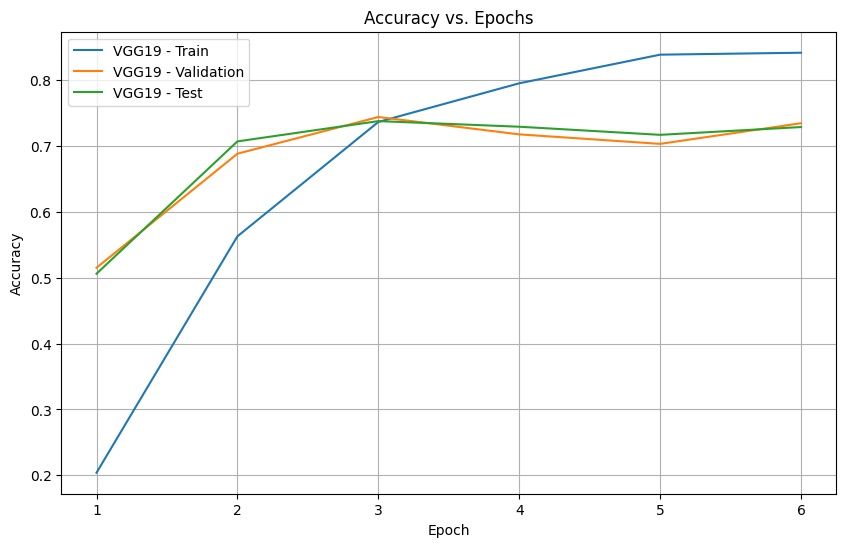

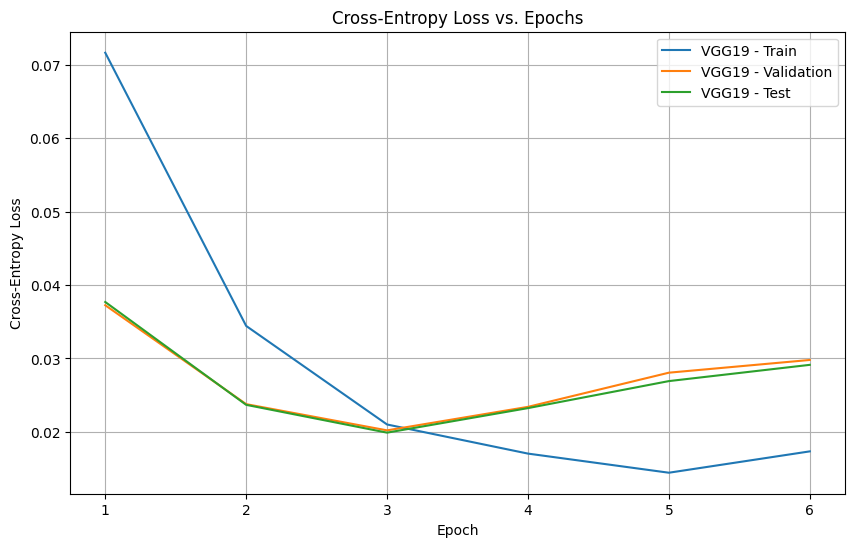

In [74]:
#Plot accuracy and cross-entropy graphs
model_names = ["VGG19"]
plot_metrics(train_accuracy_list, val_accuracy_list, test_accuracy_list, "Accuracy", model_names)
plot_metrics(train_loss_list, val_loss_list, test_loss_list, "Cross-Entropy Loss", model_names)

## YOLOV5

### model setup

In [55]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

# Import the YOLOv5 class according to the updated structure
from yolov5.models.experimental import attempt_load


Cloning into 'yolov5'...
remote: Enumerating objects: 15829, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 15829 (delta 21), reused 35 (delta 10), pack-reused 15768
Receiving objects: 100% (15829/15829), 14.66 MiB | 20.53 MiB/s, done.
Resolving deltas: 100% (10830/10830), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.6/607.6 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.8 MB/s eta 0

In [56]:
%cd ../yolov5
from utils.downloads import attempt_download

p5 = ['n', 's', 'm', 'l', 'x']  # P5 models
cls = [f'{x}-cls' for x in p5]  # classification models

for x in cls:
    attempt_download(f'weights/yolov5{x}.pt')

/content/yolov5


WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

100%|██████████| 4.87M/4.87M [00:00<00:00, 16.2MB/s]

100%|██████████| 10.5M/10.5M [00:00<00:00, 21.5MB/s]

100%|██████████| 24.9M/24.9M [00:00<00:00, 72.0MB/s]

100%|██████████| 50.9M/50.9M [00:00<00:00, 67.9MB/s]

100%|██████████| 92.0M/92.0M [00:01<00:00, 71.4MB/s]



### model train

In [80]:
!python classify/train.py --model yolov5s-cls.pt --data /content/splited/ --epochs 50 --img 224 --pretrained weights/yolov5s-cls.pt

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

classify/train: model=yolov5s-cls.pt, data=/content/splited/, epochs=50, batch_size=64, imgsz=224, nosave=False, cache=None, device=, workers=8, project=runs/train-cls, name=exp, exist_ok=False, pretrained=weights/yolov5s-cls.pt, optimizer=Adam, lr0=0.001, decay=5e-05, label_smoothing=0.1, cutoff=None, dropout=None, verbose=False, seed=0, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-196-gacdf73b Python-3.10.6 torch-2.0.1

### evaluate

result of the model are logged in this file

In [12]:
import pandas as pd
colnames = ['epoch', 'train_loss', 'v_loss','train_top1_accuracy','train_top5_accuracy','val_top1_accuracy','val_top5_accuracy','test_loss','test_top1_accuracy','test_top5_accuracy','lr/0']
res = pd.read_csv('/content/results (3).csv', names=colnames,header=1)
res.columns

Index(['epoch', 'train_loss', 'v_loss', 'train_top1_accuracy',
       'train_top5_accuracy', 'val_top1_accuracy', 'val_top5_accuracy',
       'test_loss', 'test_top1_accuracy', 'test_top5_accuracy', 'lr/0'],
      dtype='object')

In [13]:
res.head()

,epoch,train_loss,v_loss,train_top1_accuracy,train_top5_accuracy,val_top1_accuracy,val_top5_accuracy,test_loss,test_top1_accuracy,test_top5_accuracy,lr/0
0,1,3.9158,3.9132,0.092891,0.33128,0.10254,0.34943,3.9163,0.092891,0.33128,0.000960
1,2,3.7801,3.7238,0.142650,0.40758,0.14236,0.41712,3.7218,0.142650,0.40758,0.000941
2,3,3.6659,3.6570,0.158290,0.45118,0.16476,0.44450,3.6420,0.158290,0.45118,0.000921
3,4,3.6195,4.1854,0.110430,0.37156,0.12295,0.38626,4.1790,0.110430,0.37156,0.000901
4,5,3.5532,3.9877,0.178670,0.45829,0.17372,0.46740,3.9889,0.178670,0.45829,0.000881


In [23]:
train_accuracy_list = res['train_top1_accuracy'].tolist()
train_loss_list = res['train_loss'].tolist()
val_accuracy_list = res['val_top1_accuracy'].tolist()
val_loss_list = res['v_loss'].tolist()
test_accuracy_list = res['test_top1_accuracy'].tolist()
test_loss_list = res['test_loss'].tolist()


In [26]:
print(train_accuracy_list)
print(val_accuracy_list)
print(test_accuracy_list)


[0.092891, 0.14265, 0.15829, 0.11043, 0.17867, 0.22559, 0.21896, 0.18057, 0.2654, 0.29005, 0.29905, 0.26351, 0.30948, 0.34028, 0.33697, 0.4019, 0.41754, 0.42796, 0.41611, 0.4237, 0.46919, 0.48626, 0.48626, 0.5128, 0.51659, 0.55308, 0.54976, 0.55498, 0.59858, 0.6128, 0.6327, 0.62322, 0.63507, 0.62512, 0.65355, 0.67346, 0.69005, 0.691, 0.68863, 0.70758, 0.70758, 0.70569, 0.73649, 0.73175, 0.74455, 0.75166, 0.73886, 0.75024, 0.75261]
[0.10254, 0.14236, 0.16476, 0.12295, 0.17372, 0.2439, 0.24988, 0.18517, 0.28721, 0.27576, 0.30463, 0.28173, 0.31508, 0.34893, 0.35689, 0.39721, 0.43056, 0.44898, 0.43405, 0.44301, 0.46889, 0.48283, 0.49129, 0.54704, 0.52763, 0.56346, 0.555, 0.55202, 0.58985, 0.63464, 0.64012, 0.63763, 0.63664, 0.63365, 0.64958, 0.68044, 0.69637, 0.7108, 0.69587, 0.72175, 0.7108, 0.71628, 0.73569, 0.73071, 0.76058, 0.75012, 0.75012, 0.76058, 0.76456]
[0.092891, 0.14265, 0.15829, 0.11043, 0.17867, 0.22559, 0.21896, 0.18057, 0.2654, 0.29005, 0.29905, 0.26351, 0.30948, 0.34028, 0

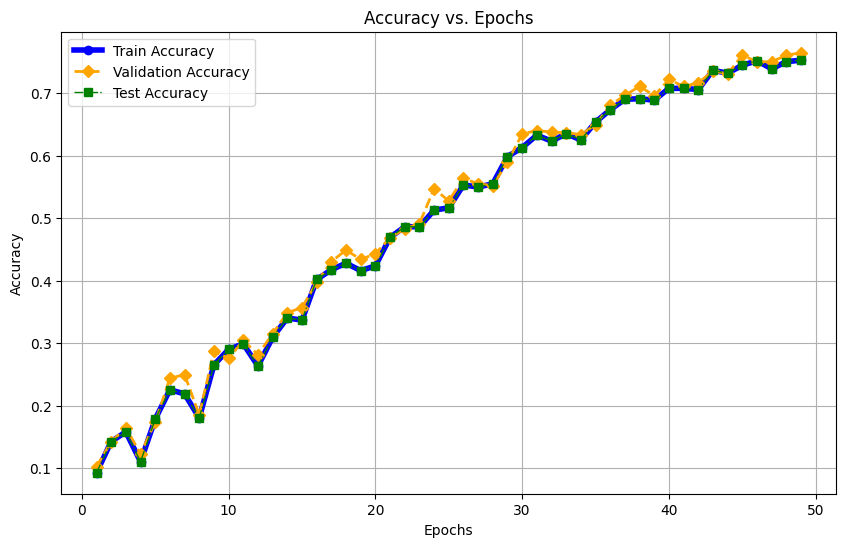

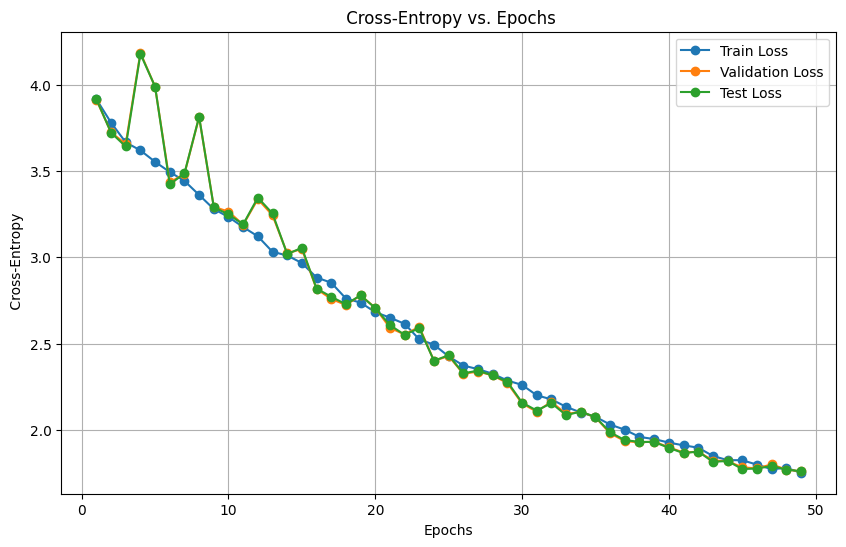

In [38]:
epochs = len(train_accuracy_list)
epochs = range(1, epochs + 1)
# Plotting the accuracy as a function of epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy_list, label='Train Accuracy', marker='o', linestyle='-', color='blue', linewidth=4)
plt.plot(epochs, val_accuracy_list, label='Validation Accuracy', marker='D', linestyle='--', color='orange', linewidth=2)
plt.plot(epochs, test_accuracy_list, label='Test Accuracy', marker='s', linestyle='-.', color='green', linewidth=1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.grid()
plt.show()

# Plotting the loss as a function of epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_list, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_list, label='Validation Loss', marker='o')
plt.plot(epochs, test_loss_list, label='Test Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel(' Cross-Entropy')
plt.title(' Cross-Entropy vs. Epochs')
plt.legend()
plt.grid()
plt.show()

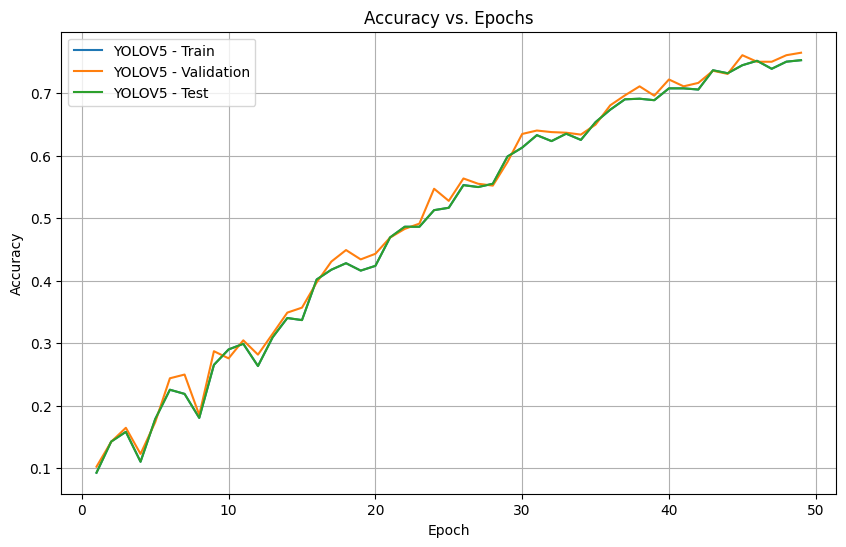

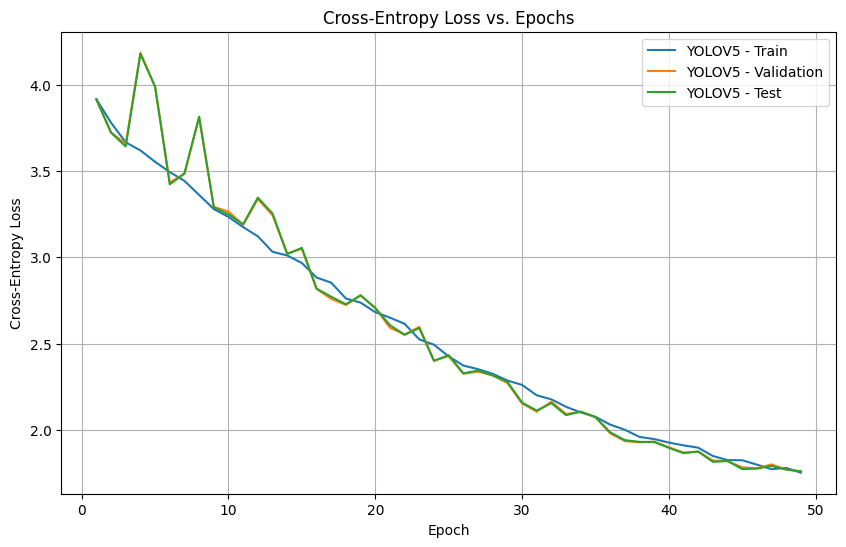

In [24]:
#Plot accuracy and cross-entropy graphs
model_names = ["YOLOV5"]
plot_metrics(train_accuracy_list, val_accuracy_list, test_accuracy_list, "Accuracy", model_names)
plot_metrics(train_loss_list, val_loss_list, test_loss_list, "Cross-Entropy Loss", model_names)